## PYPSA-USA Technical Appendix

PYPSA-USA Repository: https://github.com/PyPSA/pypsa-usa/tree/master


### PYPSA-USA Data Sources 

|Input Data | Description | Source |
| --- | --- | --- |
|BA_Shapes_new| Shape file used as inputs to produce geojson images. The shape file inputs return country and state boundary geojson .png files. | PYPSA-USA Repository | 
| BOEM_CA_OSW_GIS| Shape file used as inputs to produce geojson images. The shape file inputs are specific to California and return onshore and offshore wind geojson .png files.| PYPSA-USA Repository|
|NERC_Regions| Shape file used as input to produce geojson images for each NERC region and subregion.| PYPSA-USA Repository|
|carbonconstraints | Data files that contain information on carbon capture rates for different types of coal and gas plants. Additionally, data is provided on carbon cap, carbon tax, methane leakage, and penalty rates.| ReEDS Constraints - PYPSA-USA Repository|
|national_generation| General mandated technology list accompanied with a general mandated technology trajectory forecast up to 2040.|ReEDS Constraints - PYPSA-USA Repository|
|reserves| Estimates on static and ramping levels at the balancing authority level (nercr) up to 2050.|ReEDS Constraints - PYPSA-USA Repository|
|state_policies| Variety of state level data for energy mandates, offshore requirements and banned technologies.| ReEDS Constraints - PYPSA-USA Repository|
|Transmissions| https://github.com/PyPSA/pypsa-usa/blob/master/workflow/repo_data/ReEDS_Constraints/transmission/README.md | ReEDS Constraints - PYPSA-USA Repository|
|membership| Data file containing NERC memberships at the transmission group level.| ReEDS Constraints - PYPSA-USA Repository|
|Reeds_Shapes| Shape file used as an input to produce geojson images for Reeds regions.| PYPSA-USA Repository|
|Locational_Mulipliers|-	Data files that contain project cost estimates for various energy requirements at Reeds regional multiplier locations.| PYPSA-USA Repository|
|Plants| Data files for ADS plant locations, EIA 860 and ADS merged plants, other plants that have merged, fuels costs for 2022, and WECC fuel regions.| PYPSA-USA Repository|
|Retrieve_casio_data| Historical daily natural gas fuel prices are retrieved from CAISO's Open Access Same-time Information System (OASIS). Data is collected on a daily basis for each Balancing Area and Fuel Region that had joined the Western Energy Imbalance Market (WEIM) during the time period designated in the configuration.| http://oasis.caiso.com/mrioasis/logon.do|
|Retrieve_cost_data_eur| Pulls cost data from PYPSA-EU (Source is unclear at the moment)| |
|Retrieve_cost_data_usa| Retrieves cost data for USA. The script starts by pulling NREL ATB power generation data for a specified year (atb_year) then NREL ATB transportation data is collected. |https://oedi-datalake.s3.amazonaws.com/ATB/electricity/parquet/{atb_year}/ATBe.parquet, https://atb-archive.nrel.gov/transportation/2020/files/2020_ATB_Data_VehFuels_Download.xlsx|
|Retrieve_databundles| Pulls NREL EFS load profile zip files. The load profiles represent projected end-use electricity demand for various scenarios of electrification (Reference, Medium, High) and technology advancement (Slow, Moderate, Rapid), developed using the EnergyPATHWAYS (EP) model, as described in Mai et al. (2018). The EP load profiles were further calibrated for use in the ReEDS capacity expansion model (detailed in forthcoming EFS analyses), thus numerical values in this data set differ slightly from those reported in Mai et al. (2018). Load profiles are provided for a subset of years (2018, 2020, 2024, 2030, 2040, 2050) and are aggregated to the state, sector, and select subsector level.| https://data.nrel.gov/submissions/126|
|Retrieve_eulp| Module to download end use load profiles (eulp) for comstock and restock data. Data is downloaded at the state level, multisector 15 minute load profiles for a year which is fixed on 2018 Amy weather data.| https://data.openei.org/submissions/4520|
|Retrieve_forcast_data| Download forecast data from external sources (CEC, WECC). Files contain hourly forecast results developed as part of the California Energy Commission's 2022 Integrated Energy Policy Report Update.| https://efiling.energy.ca.gov/GetDocument.aspx?tn=248357, https://efiling.energy.ca.gov/GetDocument.aspx?tn=248355, https://efiling.energy.ca.gov/GetDocument.aspx?tn=248353, https://www.wecc.org/Reliability/WECC%202030%20ADS%20PCM%202020-12-16%20(V1.5)%20Public%20Data.zip, https://www.wecc.org/Reliability/2032%20ADS%20PCM%20V2.3.2%20Public%20Data.zip|
|Retrieve_gridemissions_data| Historical electrical generation, demand, interchange, and emissions data are retrieved from the GridEmissions. Data is downloaded at hourly temporal resolution and at a spatial resolution of balancing authority region.|https://gridemissions.jdechalendar.su.domains/#/code. 


In [2]:
# Import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import pypsa
import gdown
import os
import sys
import netCDF4 as nc
import scipy
import cartopy.io.shapereader as shpreader
import geopandas as gpd
import matplotlib.pyplot as plt
import atlite
import xarray as xr
import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as plate
import cartopy.io.shapereader as shpreader

from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
from matplotlib.lines import Line2D
from pypsa.statistics import StatisticsAccessor, get_bus_and_carrier

In [3]:
# Ensure that the pypsa-usa_technical_appendix.ipynb file is saved within the "workflow" folder of the PYPSA-USA repository.
current_dir = os.path.dirname(os.path.abspath('pypsa-usa_technical_appendix.ipynb'))

# Define path to scripts subfolder within the PYPSA-USA repository
subfolder_path = os.path.join(current_dir, 'scripts')
sys.path.append(subfolder_path)


In [4]:
# Import network
network = pypsa.Network()

# UPDATE to user specific file path
file_path = "C:/Users/alexa/Policy_Integrity/elec_s_145_ec_lv1.0_Ep_E_operations.nc"

# Import network from file
network.import_from_netcdf(path=file_path)


INFO:pypsa.io:Imported network elec_s_145_ec_lv1.0_Ep_E_operations.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units


In [108]:
# Import data for USA plot
buses = network.buses
carriers = network.carriers
generators = network.generators
storage_units = network.storage_units
lines = network.lines
links = network.links

# Create a series for the size of buses in the network
bus_sizes = generators.groupby("bus").p_nom_opt.sum()
line_values = lines.s_nom_opt
link_values = links.p_nom_opt

In [6]:
# Generate geopandas state boarders 
STATES_TO_REMOVE = [
    "Hawaii",
    "Alaska",
    "Commonwealth of the Northern Mariana Islands",
    "United States Virgin Islands",
    "Guam",
    "Puerto Rico",
    "American Samoa",
]

shpfilename = shpreader.natural_earth(
    resolution="10m", category="cultural", name="admin_1_states_provinces"
)
reader = shpreader.Reader(shpfilename)
gdf_states = reader.records()
data = []
for r in gdf_states:
    attr = r.attributes
    if (attr["iso_a2"] in ["US"]) and (attr["name"] not in STATES_TO_REMOVE):
        data.append(
            [
                attr["name"],
                attr["iso_a2"],
                attr["latitude"],
                attr["longitude"],
                r.geometry,
            ]
        )
gdf_states = gpd.GeoDataFrame(
    data, columns=["name", "country", "x", "y", "geometry"]
).set_crs(4326)

c:\Users\alexa\Policy_Integrity\pypsa-usa\workflow\scripts\plot_network_maps.py:387: FutureWarning:

Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.

c:\Users\alexa\anaconda3\envs\pypsa-usa\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".

c:\Users\alexa\anaconda3\envs\pypsa-usa\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



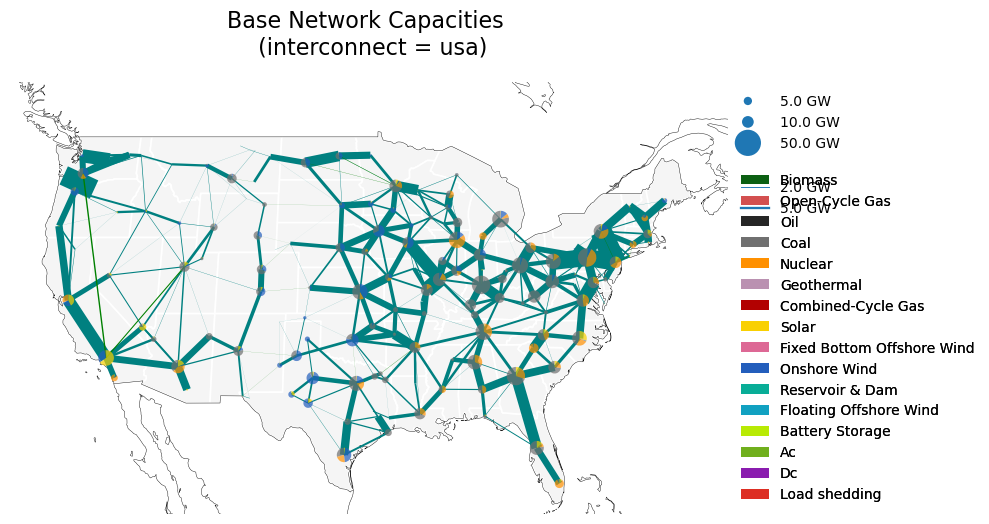

In [35]:
# Import capacity plot function from pypsa-usa scripts.
from plot_network_maps import plot_base_capacity_map, get_capacity_base

# Plot capacity map
plot_base_capacity_map(
    n=network,
    regions=gdf_states, 
    carriers=["solar", "wind", "onwind", "offwind", "ror", "nuclear", "gas", "coal", "battery"],
    save="C:/Users/alexa/Policy_Integrity/figures/USA_capacity_map.png",
    interconnect="usa",
)

#

c:\Users\alexa\anaconda3\envs\pypsa-usa\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".

c:\Users\alexa\anaconda3\envs\pypsa-usa\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



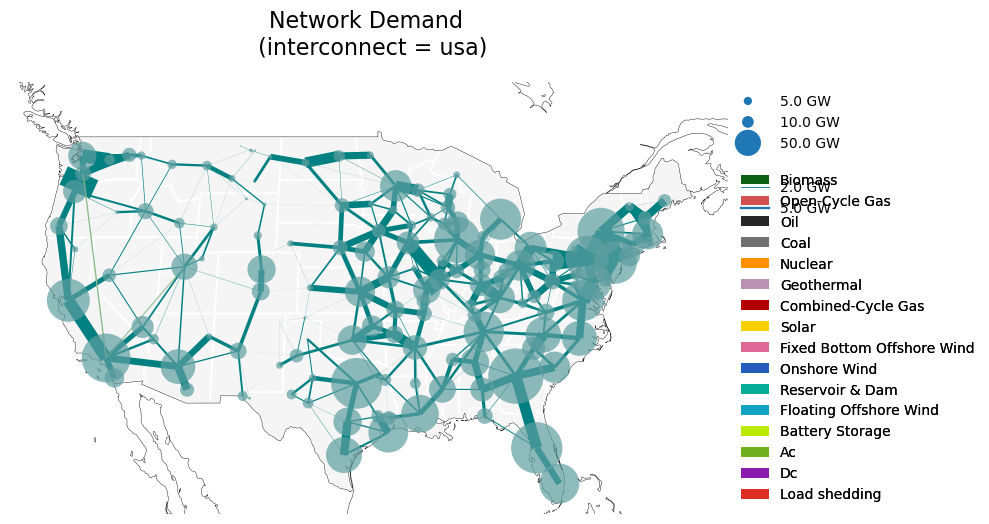

In [36]:
from plot_network_maps import plot_demand_map

# plot demand map
plot_demand_map(
    n=network,
    regions=gdf_states,
    carriers=["solar", "wind", "onwind", "offwind", "ror", "nuclear", "gas", "coal", "battery"],
    save="C:/Users/alexa/Policy_Integrity/figures/USA_demand_map.png",
    interconnect="usa",
)


## Summary of Input Data

### Energy Supply Statistics 

In [231]:
def get_primary_energy_use(n: pypsa.Network) -> pd.DataFrame:
    """
    Gets timeseries primary energy use by bus and carrier.
    """

    link_energy_use = (
        StatisticsAccessor(n)
        .withdrawal(
            comps=["Link", "Store", "StorageUnit"],
            aggregate_time=False,
            groupby=get_bus_and_carrier,
        )
        .droplevel("component")
    )

    gen_dispatch = (
        StatisticsAccessor(n)
        .supply(
            aggregate_time=False,
            comps=["Generator"],
            groupby=pypsa.statistics.get_name_bus_and_carrier,
        )
        .droplevel("component")
    )
    gen_eff = n.get_switchable_as_dense("Generator", "efficiency")

    gen_energy_use = gen_dispatch.T.mul(1 / gen_eff, axis=0, level="name").T.droplevel(
        "name",
    )

    return (
        pd.concat([gen_energy_use, link_energy_use])
        .groupby(["bus", "carrier"])
        .sum()
    )


energy_use = get_primary_energy_use(network)

# Add zonal features to energy use dataframe 
def add_zonal_features(energy_use: pd.DataFrame, buses: pd.DataFrame):
    """
    Returns energy_use dataframe with additional zonal features from buses dataframe.
    """
    buses_select = buses[["reeds_zone", "reeds_ba", "interconnect"]].reset_index().rename(columns={"Bus": "bus"})

    energy_use_zonal = energy_use.reset_index()

    energy_use_zonal.columns = energy_use_zonal.columns.droplevel(1)

    energy_use_zonal = energy_use_zonal.merge(buses_select, on="bus")

    energy_use_zonal = energy_use_zonal.set_index(["bus", "carrier", "reeds_zone", "reeds_ba", "interconnect"])

    timestep = energy_use.columns
    energy_use_zonal.columns = timestep

    return energy_use_zonal


energy_use_zonal = add_zonal_features(energy_use, buses)
energy_use_zonal.head()


period                                                                  2019  \
timestep                                                 2019-01-01 00:00:00   
bus     carrier         reeds_zone reeds_ba interconnect                       
p1000 0 Biomass         p100       PJM      Eastern                 7.897490   
        Load shedding   p100       PJM      Eastern                 0.000041   
        Onshore Wind    p100       PJM      Eastern                 0.000000   
        Open-Cycle Gas  p100       PJM      Eastern                 0.006612   
        Reservoir & Dam p100       PJM      Eastern                 1.276630   

period                                                                        \
timestep                                                 2019-01-01 01:00:00   
bus     carrier         reeds_zone reeds_ba interconnect                       
p1000 0 Biomass         p100       PJM      Eastern                 7.897493   
        Load shedding   p100       PJM      Eastern                 0.000041   
        Onshore Wind    p100       PJM      Eastern                 0.000000   
        Open-Cycle Gas  p100       PJM      Eastern                 0.006612   
        Reservoir & Dam p100       PJM      Eastern                 1.052163   

period                                                                        \
timestep                                                 2019-01-01 02:00:00   
bus     carrier         reeds_zone reeds_ba interconnect                       
p1000 0 Biomass         p100       PJM      Eastern                 7.897502   
        Load shedding   p100       PJM      Eastern                 0.000041   
        Onshore Wind    p100       PJM      Eastern                 0.000000   
        Open-Cycle Gas  p100       PJM      Eastern                 0.006617   
        Reservoir & Dam p100       PJM      Eastern                 0.736627   

period                                                                        \
timestep                                                 2019-01-01 03:00:00   
bus     carrier         reeds_zone reeds_ba interconnect                       
p1000 0 Biomass         p100       PJM      Eastern                 7.897505   
        Load shedding   p100       PJM      Eastern                 0.000041   
        Onshore Wind    p100       PJM      Eastern                 0.000000   
        Open-Cycle Gas  p100       PJM      Eastern                 0.006614   
        Reservoir & Dam p100       PJM      Eastern                 0.481728   

period                                                                        \
timestep                                                 2019-01-01 04:00:00   
bus     carrier         reeds_zone reeds_ba interconnect                       
p1000 0 Biomass         p100       PJM      Eastern                 7.897512   
        Load shedding   p100       PJM      Eastern                 0.000041   
        Onshore Wind    p100       PJM      Eastern                 0.000000   
        Open-Cycle Gas  p100       PJM      Eastern                 0.006617   
        Reservoir & Dam p100       PJM      Eastern                 0.478633   

period                                                                        \
timestep                                                 2019-01-01 05:00:00   
bus     carrier         reeds_zone reeds_ba interconnect                       
p1000 0 Biomass         p100       PJM      Eastern                 7.897506   
        Load shedding   p100       PJM      Eastern                 0.000041   
        Onshore Wind    p100       PJM      Eastern                 0.000000   
        Open-Cycle Gas  p100       PJM      Eastern                 0.006614   
        Reservoir & Dam p100       PJM      Eastern                 0.467892   

period                                                                        \
timestep                                                 2019-01-01 06:00:

In [235]:
# number of unique reeds_zones
energy_use_zonal.index.get_level_values("reeds_zone").nunique()


133

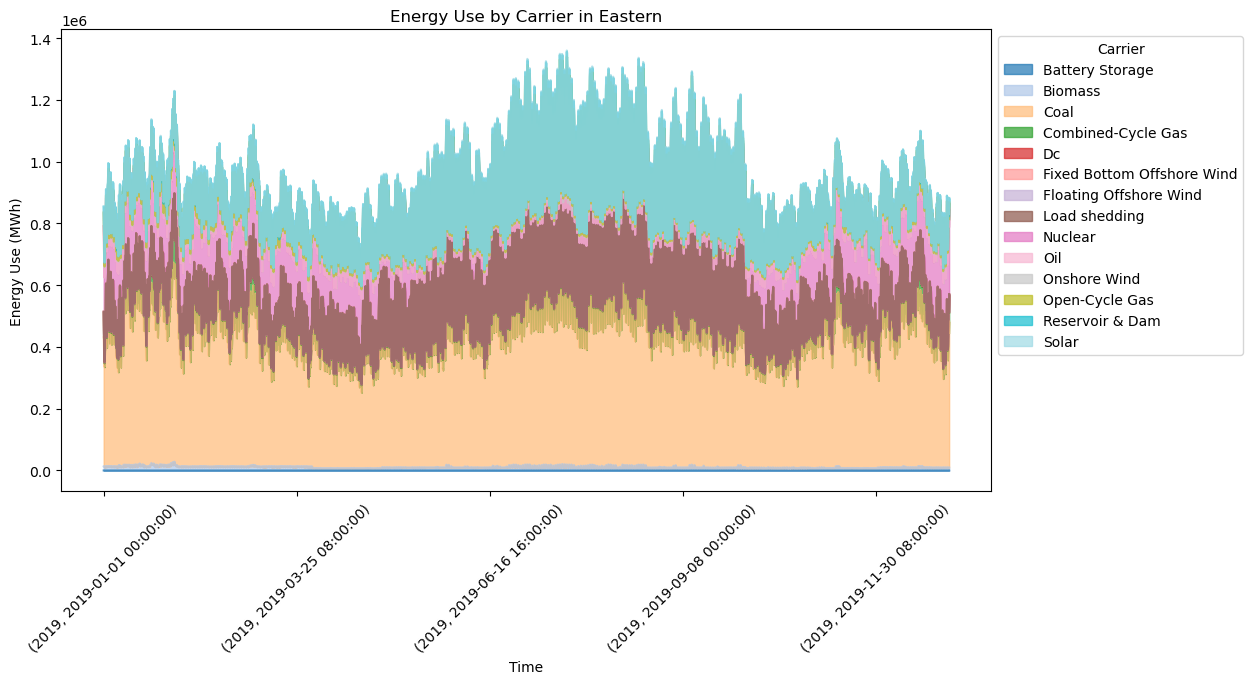

In [240]:
def plot_energy_use_by_carrier(energy_use_zonal: pd.DataFrame, interconnect: str):
    """
    Plots energy use by carrier for a given interconnect.
    """
    # Select data for interconnect
    data = energy_use_reset.loc(axis=0)[:, :, :, :, interconnect].groupby(["carrier"]).sum().T

    # Plot data
    fig, ax = plt.subplots(figsize=(12, 6))
    data.plot.area(ax=ax, cmap="tab20", alpha=0.7)
    ax.set_title(f"Energy Use by Carrier in {interconnect}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Energy Use (MWh)")
    ax.legend(title="Carrier", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.show()

# Plot energy use by carrier for the USA interconnect
plot_energy_use_by_carrier(energy_use_zonal, "Eastern")


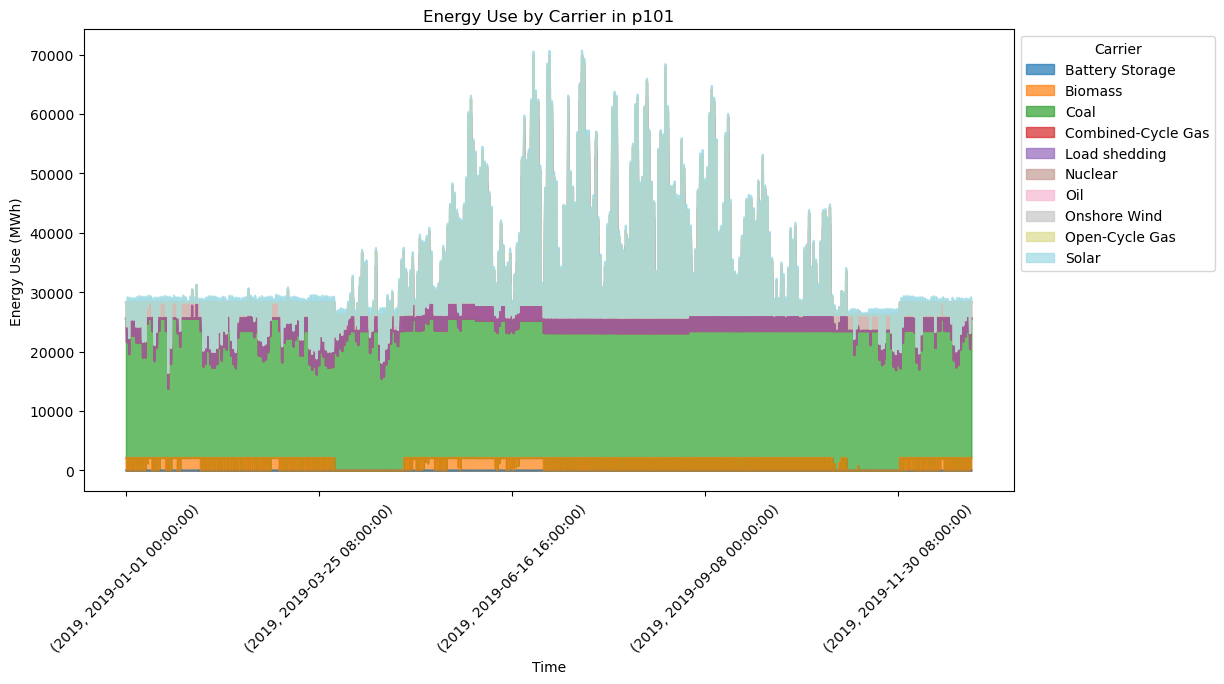

In [218]:
def plot_energy_use_by_carrier_zone(energy_use_reset: pd.DataFrame, reeds_zone: str):
    """
    Plots energy use by carrier for a given reeds zone.
    """
    # Select data for reeds zone
    data = energy_use_reset.loc(axis=0)[:, :, reeds_zone, :, :].groupby(["carrier"]).sum().T

    # Plot data
    fig, ax = plt.subplots(figsize=(12, 6))
    data.plot.area(ax=ax, cmap="tab20", alpha=0.7)
    ax.set_title(f"Energy Use by Carrier in {reeds_zone}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Energy Use (MWh)")
    ax.legend(title="Carrier", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.show()

# Plot energy use by carrier for the Eastern reeds zone
plot_energy_use_by_carrier_zone(energy_use_reset, "p101")


In [22]:
# Get energy timeseries production 
from summary import get_energy_timeseries

energy_timeseries = get_energy_timeseries(network)
energy_timeseries.head()

c:\Users\alexa\Policy_Integrity\pypsa-usa\workflow\scripts\summary.py:122: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



CCGT         OCGT      biomass  \
period timestep                                                      
2019   2019-01-01 00:00:00  62245.034388  1989.180540  5561.844706   
       2019-01-01 01:00:00  65660.979506  1954.570290  5495.899771   
       2019-01-01 02:00:00  59926.120179  1906.086444  5490.956062   
       2019-01-01 03:00:00  50472.666075  1915.975630  5421.497678   
       2019-01-01 04:00:00  42519.262265  1839.598965  5388.727208   

                                     coal   geothermal         hydro  \
period timestep                                                        
2019   2019-01-01 00:00:00  180462.663876  3270.173667  33466.369505   
       2019-01-01 01:00:00  178539.524718  3270.178987  34338.717962   
       2019-01-01 02:00:00  173470.891201  3270.179081  34821.180094   
       2019-01-01 03:00:00  167440.186061  3270.179096  34688.534378   
       2019-01-01 04:00:00  163139.466644  3270.179097  33682.253865   

                                load        nuclear  offwind  \
period timestep                                                
2019   2019-01-01 00:00:00  2.108123  105280.953204      0.0   
       2019-01-01 01:00:00  0.012943  105280.953206      0.0   
       2019-01-01 02:00:00  0.012920  105280.953454      0.0   
       2019-01-01 03:00:00  0.012786  105250.991190      0.0   
       2019-01-01 04:00:00  0.012781  105036.302019      0.0   

                            offwind_floating        oil        onwind  \
period timestep                                                         
2019   2019-01-01 00:00:00               0.0  76.323042  50969.053763   
       2019-01-01 01:00:00               0.0  66.310131  52037.213842   
       2019-01-01 02:00:00               0.0  57.659399  54597.961483   
       2019-01-01 03:00:00               0.0  54.733192  56359.953999   
       2019-01-01 04:00:00               0.0  52.904278  56565.753616   

                                  solar           DC     battery  
period timestep                                                   
2019   2019-01-01 00:00:00  4440.783609  6489.721816  216.193754  
       2019-01-01 01:00:00  1096.949522  6521.788918  238.624622  
       2019-01-01 02:00:00     0.000000  6527.035317  178.517364  
       2019-01-01 03:00:00     0.000000  6528.416973  132.638865  
       2019-01-01 04:00:00     0.000000  6530.271181  148.363588

### Energy Demand Statistics

In [26]:
from summary import get_demand_timeseries, get_demand_base

# Get demand timeseries
demand_timeseries = get_demand_timeseries(network)
demand_timeseries.head()

Demand
period timestep                          
2019   2019-01-01 00:00:00  447061.251583
       2019-01-01 01:00:00  447117.950828
       2019-01-01 02:00:00  438085.539734
       2019-01-01 03:00:00  423773.346730
       2019-01-01 04:00:00  410253.428908

In [157]:
#  Gets Nodal Sum of Demand
demand_base = get_demand_base(network)
demand_base

Load
p1000 0    2.986252e+06
p101 0     1.360568e+08
p1010 0    1.503102e+08
p1020 0    9.065881e+07
p1030 0    9.627218e+07
               ...     
p950 0     3.092858e+07
p960 0     5.551537e+07
p970 0     7.177041e+07
p980 0     6.956619e+07
p990 0     9.622061e+07
Length: 145, dtype: float64

### Energy Capacity Statistics 

In [31]:
from summary import get_capacity_base

#Gets starting capacities. NOTE: Link capacities are grouped by both bus0 and bus1!! It is up to the user to filter this by bus on the returned dataframe.

capacity_base = get_capacity_base(network)
capacity_base.head()

bus      carrier
p1000 0  OCGT       1.500000e+01
         biomass    2.000000e+00
         hydro      3.852431e+00
         load       1.000000e+09
         onwind     0.000000e+00
Name: p_nom, dtype: float64

### Cost Statistics

In [44]:
from summary import get_capital_costs, get_generator_marginal_costs, get_fuel_costs

def get_generator_marginal_costs(
    n: pypsa.Network,
    resample_period: str = "d",
) -> pd.DataFrame:
    """
    Gets generator marginal costs of Units with static MC and units with time
    varying MC.
    """
    df_mc = (
        n.get_switchable_as_dense("Generator", "marginal_cost")
        .resample(resample_period)
        .mean()
    )
    df_long = pd.melt(
        df_mc.reset_index(),
        id_vars=["snapshot"],
        var_name="Generator",
        value_name="Value",
    )
    df_long["Carrier"] = df_long["Generator"].map(n.generators.carrier)
    return df_long

gen_mc = get_generator_marginal_costs(network)

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'MultiIndex'

In [244]:
generators

,carrier,bus,p_nom_min,p_nom,ramp_limit_up,ramp_limit_down,efficiency,marginal_cost,capital_cost,p_min_pu,...,committable,start_up_cost,shut_down_cost,stand_by_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,
p1000 0 OCGT,OCGT,p1000 0,15.000000,1.500000e+01,1.0,1.0,0.293,0.009487,76622.580322,0.0,...,False,0.0,0.0,0.0,0,0,1,0,1.0,1.0
p1000 0 biomass,biomass,p1000 0,2.000000,2.000000e+00,1.0,1.0,0.253,0.009388,442969.033500,0.0,...,False,0.0,0.0,0.0,0,0,1,0,1.0,1.0
p1000 0 hydro,hydro,p1000 0,3.852431,3.852431e+00,NaN,NaN,0.900,0.010145,114675.552782,0.0,...,False,0.0,0.0,0.0,0,0,1,0,1.0,1.0
p1000 0 onwind,onwind,p1000 0,0.000000,0.000000e+00,NaN,NaN,1.000,0.009191,88580.327766,0.0,...,False,0.0,0.0,0.0,0,0,1,0,1.0,1.0
p1000 0 solar,solar,p1000 0,12.500000,1.250000e+01,NaN,NaN,1.000,0.010771,122729.423325,0.0,...,False,0.0,0.0,0.0,0,0,1,0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p950 0 load,load,p950 0,0.000000,1.000000e+09,NaN,NaN,1.000,1.010436,0.000000,0.0,...,False,0.0,0.0,0.0,0,0,1,0,1.0,1.0
p960 0 load,load,p960 0,0.000000,1.000000e+09,NaN,NaN,1.000,1.010954,0.000000,0.0,...,False,0.0,0.0,0.0,0,0,1,0,1.0,1.0
p970 0 load,load,p970 0,0.000000,1.000000e+09,NaN,NaN,1.000,1.009591,0.000000,0.0,...,False,0.0,0.0,0.0,0,0,1,0,1.0,1.0
